In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [2]:
# Load CSV
df = pd.read_csv("/workspaces/House_Price_Prediction/data (1).csv")

print("Shape:", df.shape)
df.head()


Shape: (4600, 18)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   float64
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  street         4600 non-null   object 
 14  city           4600 non-null   object 
 15  statezip       4600 non-null   object 
 16  country        4600 non-null   object 
 17  year           4600 non-null   int32  
 18  month   

In [17]:
# Remove rows with missing values
df.dropna(inplace=True)

In [3]:
# Drop duplicates
df = df.drop_duplicates()

# Convert date column if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df = df.drop(columns=["date"])

# Standardize categorical fields
for col in ["street","city","statezip","country"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Check missing values
print(df.isnull().sum().sort_values(ascending=False).head(10))


price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
view           0
condition      0
sqft_above     0
dtype: int64


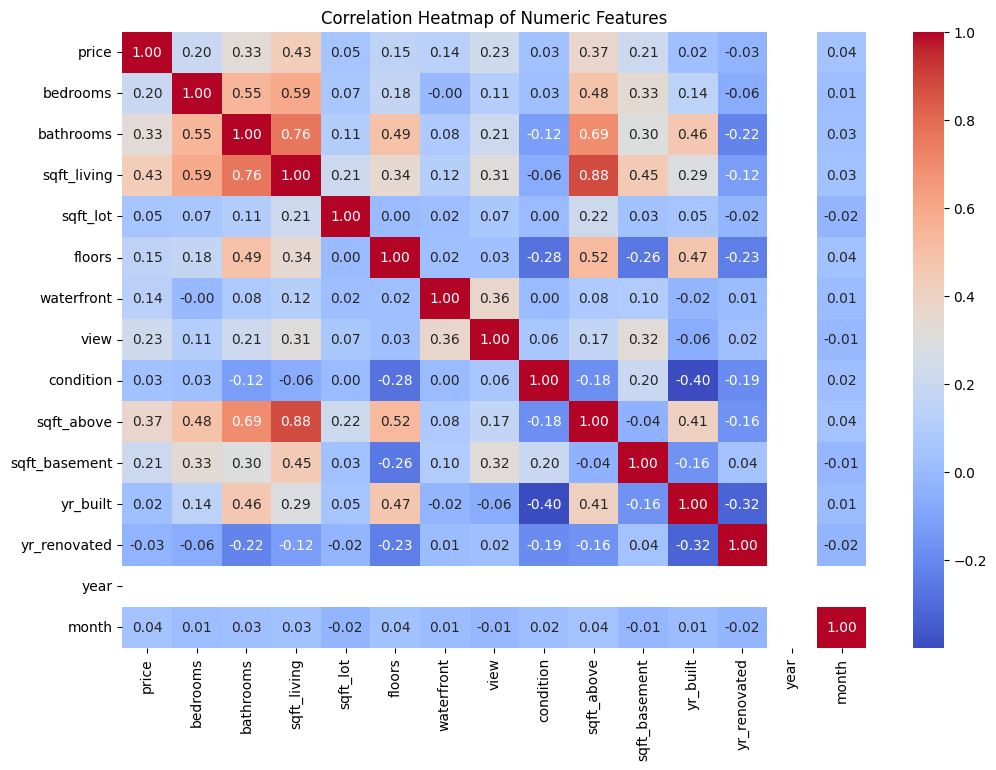

Correlation with price:
price            1.000000
sqft_living      0.430410
sqft_above       0.367570
bathrooms        0.327110
view             0.228504
sqft_basement    0.210427
bedrooms         0.200336
floors           0.151461
waterfront       0.135648
sqft_lot         0.050451
month            0.041081
condition        0.034915
yr_built         0.021857
yr_renovated    -0.028774
year                  NaN
Name: price, dtype: float64


In [14]:


# Correlation matrix for numeric features only
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Quick look at correlation with target 'price'
if "price" in corr_matrix.columns:
    print("Correlation with price:")
    print(corr_matrix["price"].sort_values(ascending=False))


In [18]:
# Summary statistics for numerical features
# This provides mean, std, min, max, etc., to understand data distribution
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,year,month
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.0,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,2014.0,5.757609
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,0.0,0.683851
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,2014.0,5.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,2014.0,5.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,2014.0,6.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000,2014.0,6.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,2014.0,7.000000


In [4]:
TARGET = "price"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train/Validation/Test split (60/20/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (2760, 18) Val: (920, 18) Test: (920, 18)


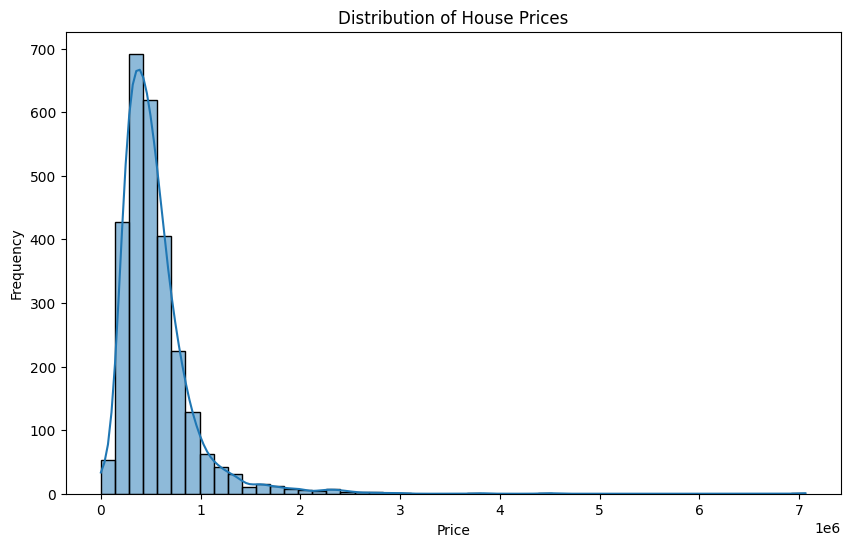

In [22]:
# Distribution of the target variable (price)
# Visualize to check for skewness; house prices often have a long tail
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [5]:
categorical_features = [c for c in X.columns if df[c].dtype == "object"]
numeric_features = [c for c in X.columns if c not in categorical_features]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features)
])


In [6]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

# Validation predictions
y_val_pred = rf_model.predict(X_val)


In [8]:
# Validation predictions 
y_val_pred = rf_model.predict(X_val)  
# Test predictions 
y_test_pred = rf_model.predict(X_test) 

# Normalized RMSE by target range 
val_range = np.max(y_val) - np.min(y_val) 
test_range = np.max(y_test) - np.min(y_test) 

val_rmse = (mean_squared_error(y_val, y_val_pred) ** 0.5) / val_range 
test_rmse = (mean_squared_error(y_test, y_test_pred) ** 0.5) / test_range

print(f"Validation Normalized RMSE: {val_rmse:.4f}") 
print(f"Test Normalized RMSE: {test_rmse:.4f}")

Validation Normalized RMSE: 0.0477
Test Normalized RMSE: 0.0370


In [21]:

# Example input (adjust values to your dataset)
sample = {
    "bedrooms": 3,
    "bathrooms": 2,
    "sqft_living": 1500,
    "sqft_lot": 4000,
    "floors": 1,
    "waterfront": 0,
    "view": 2,
    "condition": 3,
    "sqft_above": 1300,
    "sqft_basement": 200,
    "yr_built": 2005,
    "yr_renovated": 0,
    "street": "main st",
    "city": "seattle",
    "statezip": "wa 98103",
    "country": "usa",
    "year": 2014,
    "month": 6
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample])

# Predict price
pred_price = rf_model.predict(sample_df)[0]
print("Predicted price:", round(pred_price, 2))

# Save the trained model with pickle
with open("house_price_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)



Predicted price: 428293.43
